In [95]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
#sysはコマンドライン引数
import sys
import csv
np.seterr(divide='ignore', invalid='ignore')
#csvファイルの読み込み、一行目はヘッダーじゃない
df = pd.read_csv("ransuu.csv",header=None)
#dfをnumpyで扱えるnp.ndarray変換
X = df.values
#配列の行数、列数の格納
X_size,dimension = X.shape
#クラスタ数宣言
c = 5
#Kはクラスタサイズ 
K = X_size /c
max_iter = 100
distances=np.zeros((X_size,c))
best_J = 10000

In [97]:
#uの最適化部分関数作成
def u_optimize(d):
    #変数定義
    u = [0] * len(d)
    for i in  range (len(d)):
        u[i] = cp.Variable()

    #目的関数定義
    Objective_function = 0 
    for i  in range(len(d)):
        Objective_function += u[i]*d[i]-0.01*(cp.entr(u[i]))
    objective = cp.Minimize(Objective_function)
    # 制約条件の定義
    zeroijou = []
    goukeiiti = []
    goukeigo = []
    constraints = []
    #0以上
    for i in range (len(d)):
        zeroijou.append(u[i]>=0)
    #合計1
    for i in range (0,len(d),c):
        #下の式はcの値によって逐次変更しないといけない
        goukeiiti.append(u[i]+u[i+1]+u[i+2]+u[i+3]+u[i+4]==1)
    #合計がクラスタサイズ
    #下の式はcの値によって逐次変更しないといけない
    goukeigo.append(sum(u[0:len(d):c])==K)
    goukeigo.append(sum(u[1:len(d):c])==K)
    goukeigo.append(sum(u[2:len(d):c])==K)
    goukeigo.append(sum(u[3:len(d):c])==K)
    goukeigo.append(sum(u[4:len(d):c])==K)
    constraints.extend(zeroijou)
    constraints.extend(goukeiiti)
    constraints.extend(goukeigo)
    
    # 問題を定義
    problem = cp.Problem(objective, constraints)
    # 最適化 (戻り値は最適化後に得られた値=最小値)
    result = problem.solve()
    #帰属度uと目的関数Jの値を抽出(ndarray型)
    u_value = np.empty(0)#空のndarrayを作成
    for i in range (len(d)):
        u_value = np.append(u_value,u[i].value)
    u = u_value
    return u,result
#クラスタ中心計算部分関数作成
def v_calculation(u_value):
    u_list = u_value.reshape([X_size,c])
    #分母計算(クラスタサイズになるはず)
    v0_denominator=0
    v1_denominator=0
    v2_denominator=0
    v3_denominator=0
    v4_denominator=0
    for i in range(0,len(d),c):
        v0_denominator += u_value[i]
    for i in range(1,len(d),c):
        v1_denominator += u_value[i]
    for i in range(2,len(d),c):
        v2_denominator += u_value[i]
    for i in range(3,len(d),c):
        v3_denominator += u_value[i]
    for i in range(4,len(d),c):
        v4_denominator += u_value[i]
    #分子計算
    v0_numerator = 0
    v1_numerator = 0
    v2_numerator = 0
    v3_numerator = 0
    v4_numerator = 0
    for i in range(X_size):
        v0_numerator += u_list[i][0]*X[i]
    for i in range(X_size):
        v1_numerator += u_list[i][1]*X[i]
    for i in range(X_size):
        v2_numerator += u_list[i][2]*X[i]
    for i in range(X_size):
        v3_numerator += u_list[i][3]*X[i]
    for i in range(X_size):
        v4_numerator += u_list[i][4]*X[i]
    v=[0 for i in range(5)]
    v[0] = v0_numerator / v0_denominator
    v[1] = v1_numerator / v1_denominator
    v[2] = v2_numerator / v2_denominator
    v[3] = v3_numerator / v3_denominator
    v[4] = v4_numerator / v4_denominator
    return v

for s in range (max_iter):
    centroids = X[np.random.choice(X_size,c)]
    #J = np.empty(0)
    for epoch in range(max_iter):
        #dにはd11,d12,d13,d14,d21,d22,,,dn1,,dncの順でリスト作る
        d=[]
        for i in range(X_size):
            for j in range(c):
                d.append(np.sum((X[i]-centroids[j])**2))
        #uの更新
        optimize_result = u_optimize(d)
        u = optimize_result[0]
        J = optimize_result[1]
        #vの更新
        v = v_calculation(u)
        new_centroids = np.array(v)
        new_centroids_kai = new_centroids[::-1,]
        # もしも重心が変わっていなかったら終了
        if (np.allclose(new_centroids, centroids) or np.allclose(new_centroids_kai, centroids)):
            print("中心が変わらないのでbreakします！")
            break
        centroids =  np.copy(new_centroids)
        #print(epoch)
        #print("回目終了")
    #目的関数が小さくなっている時、cluster,best_J,best_centoridsの更新を行う
    if best_J > J:
        u_list = u.reshape([X_size,c])
        np_cluster = np.argmax(u_list,axis=1)
        #最適な目的関数の更新
        best_J = J
        #目的関数が小さくなるときの重心を格納
        best_centroids = np.copy(new_centroids)
    print(s)
    print("回目のクラスタリング結果↓")
    print(best_J)
    print(best_centroids)
    print("終了")
print(np_cluster)
print(best_J)
print(best_centroids)

中心が変わらないのでbreakします！
0
回目のクラスタリング結果↓
3.4649619418042086
[[0.80648741 0.21985161]
 [0.78526304 0.7951157 ]
 [0.23351715 0.25614849]
 [0.13979524 0.78980592]
 [0.50396729 0.53581152]]
終了
中心が変わらないのでbreakします！
1
回目のクラスタリング結果↓
3.464961941739127
[[0.78526299 0.79511582]
 [0.13979509 0.78980572]
 [0.23351731 0.25614833]
 [0.50396731 0.53581169]
 [0.80648743 0.21985167]]
終了
中心が変わらないのでbreakします！
2
回目のクラスタリング結果↓
3.464961941739127
[[0.78526299 0.79511582]
 [0.13979509 0.78980572]
 [0.23351731 0.25614833]
 [0.50396731 0.53581169]
 [0.80648743 0.21985167]]
終了
中心が変わらないのでbreakします！
3
回目のクラスタリング結果↓
3.4649619416874295
[[0.50396743 0.53581351]
 [0.78526243 0.7951171 ]
 [0.13979353 0.7898036 ]
 [0.80648768 0.21985237]
 [0.23351904 0.25614666]]
終了
中心が変わらないのでbreakします！
4
回目のクラスタリング結果↓
3.4649619416874295
[[0.50396743 0.53581351]
 [0.78526243 0.7951171 ]
 [0.13979353 0.7898036 ]
 [0.80648768 0.21985237]
 [0.23351904 0.25614666]]
終了
中心が変わらないのでbreakします！
5
回目のクラスタリング結果↓
3.4649619416874295
[[0.50396743 0.53581351]
 [

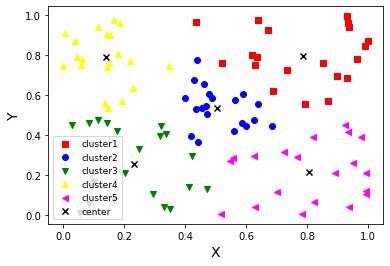

In [98]:
#グラフ
colors = ['red', 'blue', 'green','yellow','fuchsia']
markers = [",", "o", "v", "^", "<", ">", "1", "2", "3"]
fig = plt.figure()
ax = fig.add_subplot(111)
#clusterはnp.array型じゃないとダメそう(リスト型だとグラフに描画されなかった)
for i in range(c):
    ax.scatter(X[:, 0][np_cluster==i], X[:, 1][np_cluster==i], color=colors[i],marker=markers[i])
ax.scatter(best_centroids[:,0],best_centroids[:,1],color="black",marker="x")
#ax.set_title('fecbo', size=16)
ax.set_xlabel("X", size=14)
ax.set_ylabel("Y", size=14)
ax.legend(['cluster1', 'cluster2','cluster3','cluster4','cluster5',"center"],fontsize=9)  # 凡例を表示

plt.show()

fig.savefig("ransuu_entro.pdf")

In [11]:
np_cluster = np.array([0,4,0,1,3,0,1,4,2,0,0,0,1,3,1,3,1,2,1,1,2,0,4,3,2,2,3,3,0,0,3,1,4,0,4,4,1,\
 2,0,0,1,4,3,2,3,3,0,0,3,1,2,4,3,2,1,3,4,4,2,3,1,1,2,2,3,3,1,0,0,0,4,2,1,4,\
 1,3,3,4,2,2,4,2,0,4,2,3,4,1,2,0,1,4,2,1,4,4,2,4,3,0])
np_cluster

array([0, 4, 0, 1, 3, 0, 1, 4, 2, 0, 0, 0, 1, 3, 1, 3, 1, 2, 1, 1, 2, 0,
       4, 3, 2, 2, 3, 3, 0, 0, 3, 1, 4, 0, 4, 4, 1, 2, 0, 0, 1, 4, 3, 2,
       3, 3, 0, 0, 3, 1, 2, 4, 3, 2, 1, 3, 4, 4, 2, 3, 1, 1, 2, 2, 3, 3,
       1, 0, 0, 0, 4, 2, 1, 4, 1, 3, 3, 4, 2, 2, 4, 2, 0, 4, 2, 3, 4, 1,
       2, 0, 1, 4, 2, 1, 4, 4, 2, 4, 3, 0])

In [16]:
best_centroids = np.array([[0.78526292,0.79511598],\
 [0.50396733, 0.53581191],\
 [0.23351751, 0.25614814],\
 [0.13979491, 0.78980546],\
 [0.80648746, 0.21985175]])
best_centroids

array([[0.78526292, 0.79511598],
       [0.50396733, 0.53581191],
       [0.23351751, 0.25614814],
       [0.13979491, 0.78980546],
       [0.80648746, 0.21985175]])

0を4\
2を0\
3を2\
4を3

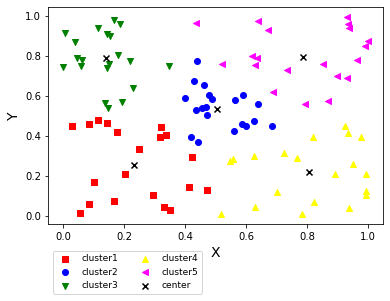

In [27]:
cluster_hensyuu = np_cluster
cluster_hensyuu_0 = np.where(cluster_hensyuu==0, 100, np_cluster)
cluster_hensyuu_1 = np.where(cluster_hensyuu_0==2, 0, cluster_hensyuu_0)
cluster_hensyuu_2 = np.where(cluster_hensyuu_1==3, 2, cluster_hensyuu_1)
cluster_hensyuu_3 = np.where(cluster_hensyuu_2==4, 3, cluster_hensyuu_2)
cluster_hensyuu_4 = np.where(cluster_hensyuu_3==100, 4, cluster_hensyuu_3)
hensyuu = cluster_hensyuu_4
#グラフ
colors = ['red', 'blue', 'green','yellow','fuchsia']
markers = [",", "o", "v", "^", "<", ">", "1", "2", "3"]
fig = plt.figure()
ax = fig.add_subplot(111)
#clusterはnp.array型じゃないとダメそう(リスト型だとグラフに描画されなかった)
for i in range(c):
    ax.scatter(X[:, 0][hensyuu==i], X[:, 1][hensyuu==i], color=colors[i],marker=markers[i])
ax.scatter(best_centroids[:,0],best_centroids[:,1],color="black",marker="x")
#ax.set_title('fecbo', size=16)
ax.set_xlabel("X", size=14)
ax.set_ylabel("Y", size=14)
#ax.legend(['cluster1', 'cluster2','cluster3','cluster4','cluster5',"center"],fontsize=9)  # 凡例を表示
ax.legend(['cluster1', 'cluster2','cluster3','cluster4','cluster5',"center"],fontsize=9,ncol=2,bbox_to_anchor=(0.0, -0.1), loc='upper left')  # 凡例を表示

plt.show()

fig.savefig("ransuu_entro.pdf",bbox_inches='tight')

In [110]:
print("帰属度とクラスタサイズの確認")
print(np.sum(u_list, axis=1))#行ごとの合計値1になるはず
print(np.sum(u_list, axis=0))#列ごとの合計値Kになるはず

帰属度とクラスタサイズの確認
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
[20. 20. 20. 20. 20.]


In [28]:
print(np.count_nonzero(hensyuu==0))
print(np.count_nonzero(hensyuu==1))
print(np.count_nonzero(hensyuu==2))
print(np.count_nonzero(hensyuu==3))
print(np.count_nonzero(hensyuu==4))

20
20
20
20
20


## ここまでが完成コード